In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from PIL import Image
import glob
import o

In [2]:
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
# model / neural network
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [4]:
# Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#import libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import max_norm
#from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Conv2D ,Flatten,Dropout,MaxPool2D, BatchNormalization
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory  
from tensorflow.keras.preprocessing import image
import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import pandas as pd
import seaborn
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.applications  import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras.constraints import max_norm
#from tensorflow.keras.utils import np_utils


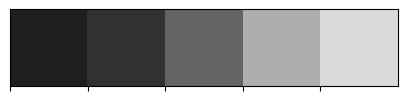

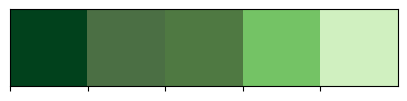

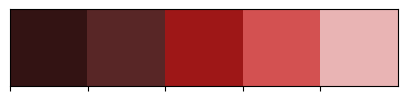

In [6]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [7]:
import numpy as np
import cv2

# Match contours to license plate or character template
def find_contours(dimensions, img):

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    # Read the binary image
    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    target_contours = []
    img_res = []
    
    # Read all contours detected
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            
            # stores the x coordinate of the character's contour, to used later for indexing the contours
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            # Draw rectangle around contour
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            
            # Display the uptated binary image with new contour
            plt.imshow(ii, cmap='gray')
            
            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)
            
            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            
            # List that stores the character's binary image (unsorted)
            img_res.append(char_copy) 
            
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    
    for idx in indices:
        # stores character images according to their index
        img_res_copy.append(img_res[idx])
        
    img_res = np.array(img_res_copy)
   
    return img_res

In [8]:
# Find characters in the resulting images and Preprocess license plate image
def segment_characters(image):
    # Resizing
    img_lp = cv2.resize(image, (233, 55))

    # Apply gray scale
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    
    # Convert to binary image
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Erode unwanted pixels
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    
    # Dilate unwanted pixels
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))
    
    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]
    
    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    
    # Estimations of character contours sizes of cropped license plates
    dimensions = [(LP_WIDTH/6) + 0.5, (LP_WIDTH/2) + 7.5, (LP_HEIGHT/10) - 15, 2 * LP_HEIGHT/3]
    
    # Visual display of binary image
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    
    # Create a binary image for next steps
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

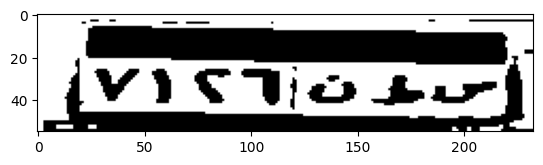

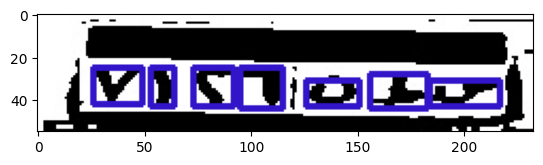

In [9]:
img = cv2.imread('D:\\car_plate_detection\\EALPR_master\\Plates_dataset\\0001_license_plate_1.png')
char = segment_characters(img)

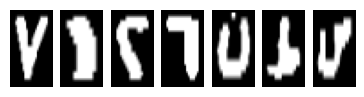

In [10]:
for i in range(len(char)):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

Image loaded successfully.
Image shape: (64, 64, 3)
Image data type: uint8


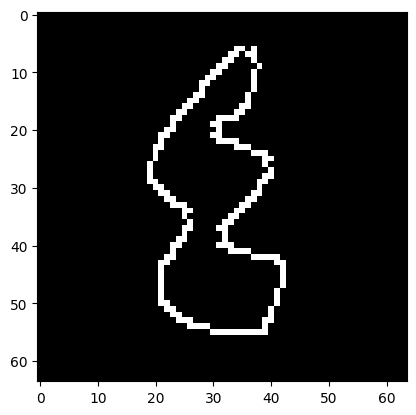

In [11]:
img = cv2.imread("D:/car_plate_detection/Arabic Letters & Numbers OCR/Dataset3/4/6w.png")
if img is not None:
    print("Image loaded successfully.")
    print("Image shape:", img.shape)
    print("Image data type:", img.dtype)
plt.imshow(img)

In [15]:
temp = []
i = 0
max = 30000
root_dir = 'D:\\car_plate_detection\\Arabic Letters & Numbers OCR\\Dataset3'

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        img = cv2.imread(file_path)
        #b, g, r = cv2.split(img)
        img = cv2.merge([r, g, b])
        img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        temp.append(img)
        i = i+1
        if i > max: 
            break
images = np.array(temp)
images.shape

(11707, 224, 224, 3)

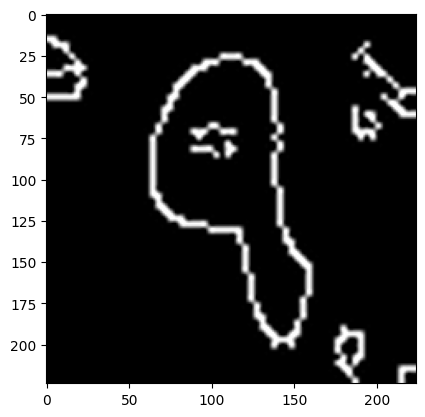

In [16]:
plt.imshow(images[881])

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model

input_img = Input(shape=(224,224,3))

encoded = Conv2D(128, (3, 3), name='e1' , activation='relu', padding='same')(input_img)
encoded = Conv2D(64, (3, 3), name='e2' , activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size=(2, 2))(encoded)

encoded = Conv2D(32, (3, 3), name='e3' , activation='relu', padding='same')(encoded)
encoded = Conv2D(16, (3, 3), name='e4' , activation='relu', padding='same')(encoded)
encoded = MaxPooling2D(pool_size=(2, 2))(encoded)


decoded = Conv2D(8, (3, 3), name='d1' , activation='relu', padding='same')(encoded)
decoded = Conv2D(16, (3, 3), name='d2' , activation='relu', padding='same')(decoded)
decoded = UpSampling2D(size=(2,2),name='d3')(decoded)

decoded = Conv2D(32, (3, 3), name='d4' , activation='relu', padding='same')(decoded)
decoded = Conv2D(64, (3, 3), name='d5' , activation='relu', padding='same')(decoded)
decoded = UpSampling2D(size=(2,2), name='d6')(decoded)

decoded = Conv2D(3, (3, 3), name='d7' , activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 e1 (Conv2D)                 (None, 224, 224, 128)     3584      
                                                                 
 e2 (Conv2D)                 (None, 224, 224, 64)      73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 e3 (Conv2D)                 (None, 112, 112, 32)      18464     
                                                                 
 e4 (Conv2D)                 (None, 112, 112, 16)      4624      
                                                           

In [26]:
encoder = Model(input_img, encoded)
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 e1 (Conv2D)                 (None, 224, 224, 128)     3584      
                                                                 
 e2 (Conv2D)                 (None, 224, 224, 64)      73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 e3 (Conv2D)                 (None, 112, 112, 32)      18464     
                                                                 
 e4 (Conv2D)                 (None, 112, 112, 16)      4624      
                                                           

In [27]:
encoded_input = Input(shape=(5,5,16))
decoder_layer = autoencoder.get_layer('d1')(encoded_input)
decoder_layer = autoencoder.get_layer('d2')(decoder_layer)
decoder_layer = autoencoder.get_layer('d3')(decoder_layer)
decoder_layer = autoencoder.get_layer('d4')(decoder_layer)
decoder_layer = autoencoder.get_layer('d5')(decoder_layer)
decoder_layer = autoencoder.get_layer('d6')(decoder_layer)
decoder_layer = autoencoder.get_layer('d7')(decoder_layer)
decoder = Model(encoded_input, decoder_layer)
decoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5, 5, 16)]        0         
                                                                 
 d1 (Conv2D)                 multiple                  1160      
                                                                 
 d2 (Conv2D)                 multiple                  1168      
                                                                 
 d3 (UpSampling2D)           multiple                  0         
                                                                 
 d4 (Conv2D)                 multiple                  4640      
                                                                 
 d5 (Conv2D)                 multiple                  18496     
                                                                 
 d6 (UpSampling2D)           multiple                  0   

In [28]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [33]:
from sklearn.model_selection import train_test_split

# Use a smaller subset for testing
X_train, X_test = train_test_split(images[:1000], test_size=0.2, random_state=1)

# Normalisation [0;1]

X_train = X_train.astype('float64') / 255.0
X_test = X_test.astype('float64') / 255.0

In [34]:
print(X_train.shape) 
print(X_test.shape) 

(800, 224, 224, 3)
(200, 224, 224, 3)


In [35]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/20

25/25 [==============================] - 328s 13s/step - loss: 0.3651 - val_loss: 0.1165
Epoch 2/20
25/25 [==============================] - 313s 12s/step - loss: 0.0941 - val_loss: 0.0790
Epoch 3/20
25/25 [==============================] - 316s 13s/step - loss: 0.0705 - val_loss: 0.0653
Epoch 4/20
25/25 [==============================] - 301s 12s/step - loss: 0.0630 - val_loss: 0.0609
Epoch 5/20
25/25 [==============================] - 312s 12s/step - loss: 0.0595 - val_loss: 0.0584
Epoch 6/20
25/25 [==============================] - 313s 13s/step - loss: 0.0576 - val_loss: 0.0569
Epoch 7/20
25/25 [==============================] - 260s 10s/step - loss: 0.0564 - val_loss: 0.0558
Epoch 8/20
25/25 [==============================] - 225s 9s/step - loss: 0.0554 - val_loss: 0.0550
Epoch 9/20
25/25 [==============================] - 220s 9s/step - loss: 0.0547 - val_loss: 0.0544
Epoch 10/20
25/25 [==============================] - 215s 9s/step - loss: 0.0543 - val_loss: 0.0541
E

ValueError: in user code:

    File "C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\user\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_5" is incompatible with the layer: expected shape=(None, 5, 5, 16), found shape=(None, 56, 56, 16)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Affichage d'images avec leur version non encodé
#comparaison avec la version obtenue après encodage / décodage

fig, ax = plt.subplots(nrows=2, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    for indice2, col in enumerate(row):
        if indice == 0:
            col.imshow(X_test[indice2].reshape(20,20,3))
        else:
            col.imshow(decoded_imgs[indice2].reshape(20,20,3))

plt.show()

In [ ]:
def custom_cosine_sim(a,b):
    return np.dot(a, b) / ( nalgnp.linalg.norm(a) * np.li.norm(b))

In [ ]:
index = 1000

plt.imshow(X_test[index])
plt.gray()
plt.show()

img_to_find = encoded_imgs[index]
img_to_find = img_to_find.reshape(-1)
img_to_find.shape

In [ ]:
from scipy import spatial 
cosine_list = []
for index_image, xt in enumerate(encoded_imgs):
    result = 1 - spatial.distance.cosine(img_to_find, xt.reshape(-1))
    cosine_list.append(dict({'res':result, 'i':index_image}))

In [ ]:
from operator import itemgetter
cosine_list.sort(key=itemgetter('res'), reverse=True)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Affichage des images similaires avec la valeur associée 

fig, ax = plt.subplots(nrows=1, ncols=10,figsize=(20, 4))
plt.gray()
for indice, row in enumerate(ax):
    print (cosine_list[indice]['i'], '-', cosine_list[indice]['res'])
    row.imshow(X_test[cosine_list[indice]['i']].reshape(20,20,3))

plt.show()